In [2]:
# load 

import sys
import os 
# path of data 
def set_path():
    if sys.platform == 'darwin':
        print("Current system is macOS")
        main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
    elif sys.platform == 'linux':
        print("Current system is Ubuntu")
        main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
    else:
        print("Current system is neither macOS nor Ubuntu")
    os.chdir(main_fold_path)
set_path()
import glob

import time
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import cross_val_score,train_test_split
from utils.utils_mine import*
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg
import collections
from utils.fnirs_utils import read_demographic, read_clinical_history, read_psychiatry_history, read_HAMD_ALL_HISTORY



def read_from_file(example_path): # Open the file and read through the first few lines to find where the data starts
    with open(example_path, 'r') as file:
        lines = file.readlines()
        data_start_line = None
        for i, line in enumerate(lines):
            if 'Data' in line:  # This should match the unique identifier of the data section
                data_start_line = i + 1
                # print(lines[data_start_line])
                break

    if data_start_line is not None:

        # Read the data section, skipping the lines of the metadata
        data = pd.read_csv(example_path, skiprows=data_start_line)

        # Now you have metadata and data as separate DataFrames
        # print(data)
    else:
        print("Data section not found.")
        
    np_data = data.to_numpy()
    ch_data = np_data[:, 1:1+52]

    return ch_data

def get_file_name(path, rest):
    file_pattern = os.path.join(path, rest)
    file_list = glob.glob(file_pattern)
    return file_list

def check_replicate_subject(all_subject):
    all_subject_index = [i[3:] for i in all_subject]
    all_subject_index = np.array(all_subject_index).astype(int)
    print(f'all_subject_index -> {all_subject_index}')
    print('all_subject_index.shape -> ', all_subject_index.shape)
    print('len(np.unique(all_subject_index)) -> ', len(np.unique(all_subject_index)))
    is_replicated = len(np.unique(all_subject_index)) != len(all_subject_index)
    print(f"Is there any replicated number in all_subject_index? {is_replicated}")
    if is_replicated:
        replicated_elements = [item for item, count in collections.Counter(all_subject_index).items() if count > 1]
        replicated_indices = np.where(np.isin(all_subject_index, replicated_elements))[0]
        print(f" Element {replicated_elements} shows up in the following indices: {replicated_indices}")
    print(f' now will return replicated_indices[0::2]')
    return replicated_indices[0::2]


follow_up_fold = 'allData/RawData'
T8_path = follow_up_fold + '/T8_fnirs/Session 2_VFT'
base_patient_path = follow_up_fold + '/Baseline_fnirs/Patients'
cli_path = 'allData/fNIRS x MDD Data_Demographics_Clinical.xlsx'

cgi_sgs_data = pd.read_excel(cli_path, sheet_name='SDS_CGI_All Timepoints')


excel_data = pd.read_excel(cli_path, sheet_name='Summary T0T8_fNIRS Analysis')

all_involve_subject = ['PT002', 'PT003', 'PT004', 'PT005', 'PT006', 'PT008', 'PT009',
       'PT010', 'PT011', 'PT012', 'PT013', 'PT014', 'PT015', 'PT016',
       'PT017', 'PT018', 'PT019', 'PT020', 'PT021', 'PT022', 'PT023',
       'PT024', 'PT025', 'PT026', 'PT027', 'PT028', 'PT029', 'PT030',
       'PT031', 'PT032', 'PT033', 'PT034', 'PT036', 'PT037', 'PT038',
       'PT039', 'PT040', 'PT041', 'PT042', 'PT043', 'PT044', 'PT045',
       'PT046', 'PT047', 'PT048', 'PT049', 'PT050', 'PT051', 'PT054',
       'PT057', 'PT058', 'PT059', 'PT060', 'PT061', 'PT062', 'PT063',
       'PT064', 'PT065', 'PT066', 'PT067', 'PT068', 'PT069', 'PT070',
       'PT071']

def impute_nan_data(data):
    input = data.copy()
    from sklearn.experimental import enable_iterative_imputer
    # Now you can import IterativeImputer
    from sklearn.impute import IterativeImputer


    # Create an instance of IterativeImputer
    imputer = IterativeImputer()

    # Fit the imputer on the clinical_data ndarray
    imputer.fit(input)

    # Transform the clinical_data ndarray by imputing the NaN values
    imputed_data = imputer.transform(input)
    return imputed_data

hamd_timeline = pd.read_excel(cli_path, sheet_name='TimelineHAMD')
data = {}
for i in range(9):
    name = hamd_timeline.values[0, i]
    value = hamd_timeline.values[1:, i]
    data[name] = value
data = pd.DataFrame(data)
filter_values = data[data['Subject ID'].isin(all_involve_subject)]
filter_values = filter_values.values 
filter_values = filter_values[:, 1:]
hamd_timeline_values = impute_nan_data(filter_values).astype(int)

avg_hamd_timeline = np.mean(hamd_timeline_values, axis=0)
nine_region_name = ['L-PSFC', 'R-PSFC', 'L-DPC', 'R-DPC', 'L-STG', 'R-STG', 'L-VPC', 'R-VPC', 'MPC']


Current system is Ubuntu


hamd_timeline_values [[25 12 17 28 18 24  8 19]
 [21 14 10 15 11 17 14 14]
 [27 17 26 24 24 25 22 20]
 [20 20 19 18 22 27 13 15]
 [17 18 19 20 23 26 27 27]
 [10  8 11 16 16 13 14 15]
 [15 17 18 17 20 19 22 17]
 [21 21 20 14 17 19 23 29]
 [22 19 19 15 21 22 23 19]
 [21 11 13 18 15 20 16 17]
 [21 21 22 16 18 14 15 15]
 [21 23 22 17 17 17 22 16]
 [19 19 25 19 20 15 18 29]
 [15 16 21 17 16 16 13 14]
 [23 15 12 10  9 11  6 10]
 [21 18 20 19 12 13 14 13]
 [19 21 23 20 21 15 18 19]
 [27 21 17 25 31 20 15 15]
 [15 11 16 13 12 12  9  9]
 [19 25 20 19 19 21 23 24]
 [15 19 17 15 11 15 10  5]
 [25 22 14 23 18 14 12 16]
 [22 11 10 15 12  8  1  3]
 [24 16 16 16 11 14 20 16]
 [30 22 28 28 25 22 20 17]
 [25 24 18 24 16 13 17  6]
 [26 28 29 21 20 13 18 13]
 [24 16 15 14  6 19 14 20]
 [26 26 19 16 21 22 21 15]
 [20  9 14 13  7 13  5 15]
 [23 26 25 27 25 23 18 22]
 [16 17 17 16 12 15 18 18]
 [20 24 22 14 25 23 12 15]
 [22 22 17  1  4  9  0  8]
 [24 16 14 24 17 16  9 22]
 [25 19 17 11  6  9  9 23]
 [22 20

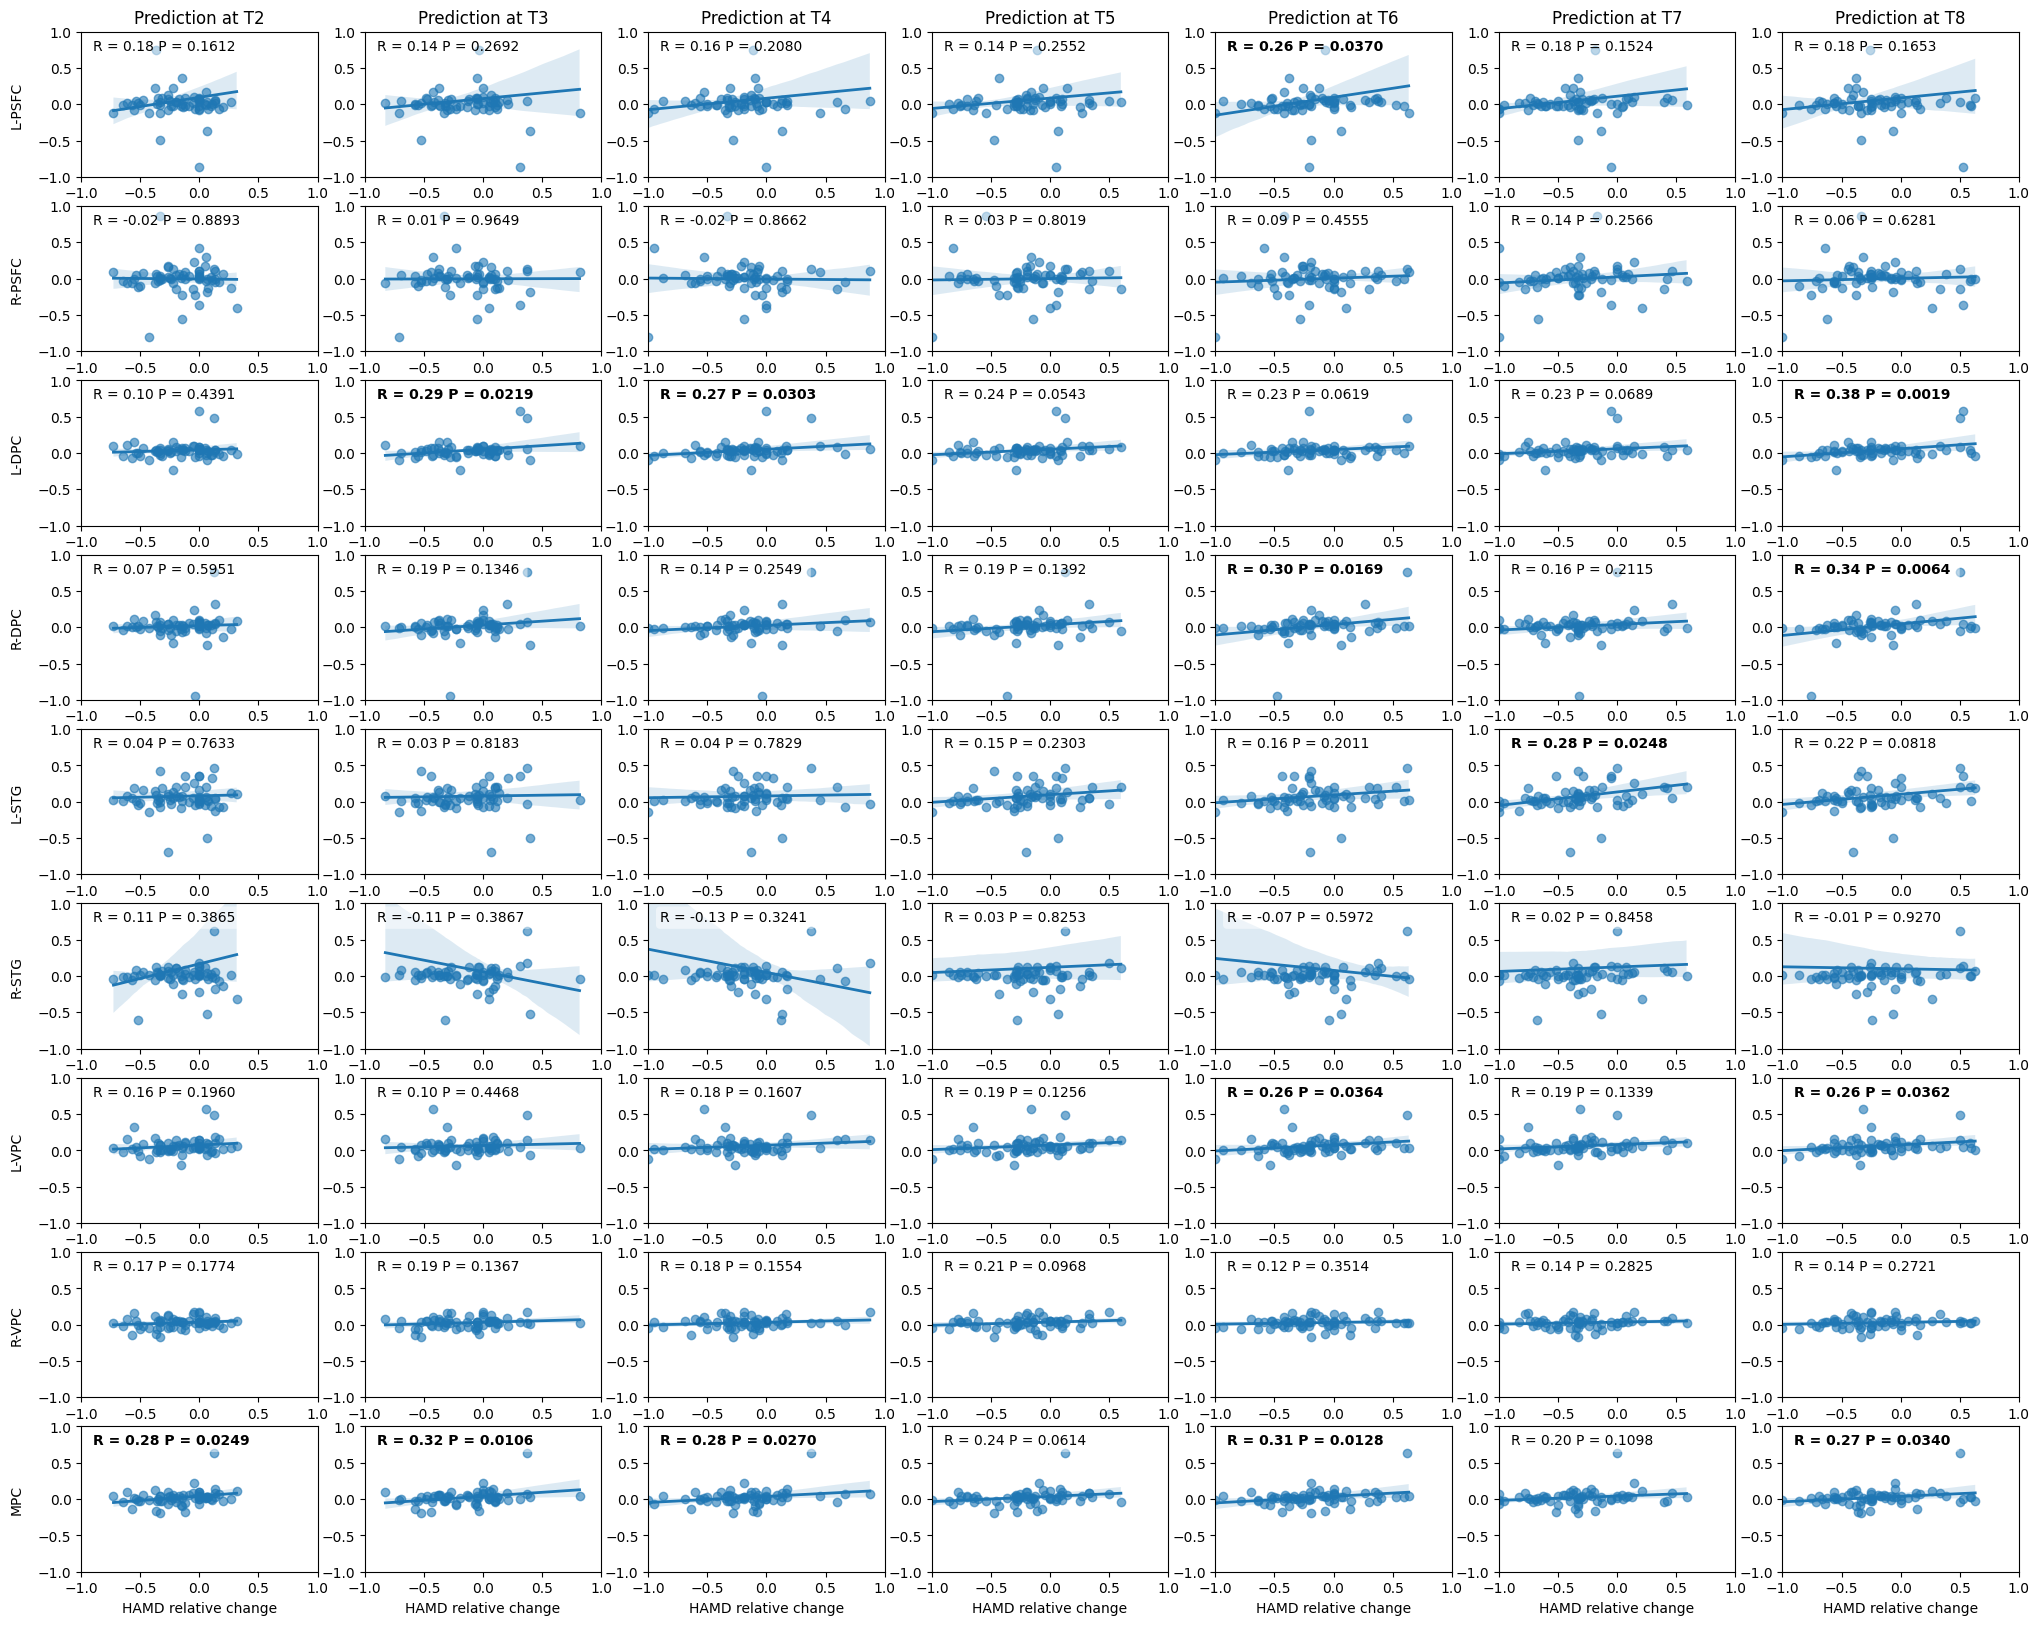

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr

# read task change hbt especailly dpc 

def plot_reg(labels, preds, ax):
    
    r, p_value = pearsonr(labels, preds)
    sns.regplot(x=labels, y=preds, ax=ax, scatter_kws={'alpha':0.6}, line_kws={"linewidth":2})
    bold = True if p_value < 0.05 else False
    ax.text(0.05, 0.95, f'R = {r:.2f} P = {p_value:.4f} ',
            transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', edgecolor='none', alpha=0.5), fontsize=10, fontweight='bold' if bold else 'normal')
    ax.set_ylim([-1, 1])  # Set y-axis limits
    ax.set_yticks([-1, -0.5, 0, 0.5, 1])  # Set y-axis ticks
    ax.set_xlim([-1, 1])  # Set y-axis limits
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])  # Set y-axis ticks    
    # Calculate Pearson correlation
    


task_change_hbt = np.load('allData/prognosis_mix_hb/pretreatment_response/task_change_hb.npy')[:, :, -1]

fig, axs = plt.subplots(9, 7, figsize=(25, 20))

new_avg_hame_timeline = hamd_timeline_values.copy()
print('hamd_timeline_values', hamd_timeline_values)
print('new_avg_hame_timeline shape', new_avg_hame_timeline.shape)
# for i in range(1, hamd_timeline_values.shape[1]):
#     if i != hamd_timeline_values.shape[1]-1:
#         new_avg_hame_timeline[:, i] = (hamd_timeline_values[:, i] + hamd_timeline_values[:, i+1] + hamd_timeline_values[:, i-1]) / 3
#     else:
#         new_avg_hame_timeline[:, i] = (hamd_timeline_values[:, i] + hamd_timeline_values[:, i-1]) / 2

                        
for region_i in range(9):              
    for i in range(avg_hamd_timeline.shape[0]-1):
        label = (new_avg_hame_timeline[:, i+1] - new_avg_hame_timeline[:, 0]) / new_avg_hame_timeline[:, 0]
        # sns.regplot(label, task_change_hbt[:, 0])
        # sns.regplot(x=label, y=task_change_hbt[:, 0], scatter_kws={'alpha':0.6}, line_kws={"linewidth":2})
        plot_reg(label, task_change_hbt[:, region_i], axs[region_i, i])
        if i == 0:
            axs[region_i, i].set_ylabel(f'{nine_region_name[region_i]}', labelpad=10)
        if region_i == 0:
            axs[region_i, i].set_title(f"Prediction at T{i+2}")
        if region_i == 8:
            axs[region_i, i].set_xlabel(f'HAMD relative change')
# plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.05, hspace=0.5)

In [14]:
for region_i in range(9):              
    region_i